In [1]:
# Initial imports
import os
import csv
import requests
import pandas as pd
from dotenv import load_dotenv
import alpaca_trade_api as tradeapi
from MCForecastTools import MCSimulation
import numpy as np
import matplotlib.pyplot as plt
import seaborn
import warnings
from pathlib import Path
import datetime as dt

#Subsequent imports
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import hvplot.pandas

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression as lr
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix
from imblearn.metrics import classification_report_imbalanced

# Enable the Matplotlib property to allow diagrams to display in Jupyter Notebook
%matplotlib inline

In [2]:
# List the ticker symbols for the stocks of interest
lst_Stocks = ['BMO.TO', 'BNS.TO', 'CM.TO', 'NA.TO','RY.TO', 'TD.TO', 'ZEB.TO','ZWB.TO', 'XGB.TO', 'CL' ]
ticker = ['TD.TO']

# Determine the Date range for the desired data
start_date = '2014-01-01'
end_date = '2022-12-31'
df = yf.download(ticker, start= start_date, end= end_date)
df = df.sort_index()


[*********************100%***********************]  1 of 1 completed


In [3]:
# Feature Engineering

# Mid Rang Variables
df['Mid_hl'] = (df['High'] + df['Low']) /2 
df['Mid_oc'] = (df['Open'] + df['Close']) /2 
df['Mid_hloc'] = (df['High'] + df['Low'] + df['Open'] + df['Close']) /4 

# Close in Range ==> Close at Low = 0, Close at High = 1
df['Close_in_range'] = 1 - ((df['High'] - df['Close']) / (df['High'] - df['Low']) )

# Daily/Weekly Returns - Average of Open and Close
df['Returns_1Day_Moc'] = df['Mid_oc'].pct_change()
df['Returns_5Day_Moc'] = df['Mid_oc'].pct_change(5)
df['Returns_30Day_Moc'] = df['Mid_oc'].pct_change(30)

# Daily/Weekly Returns - Average of High Low Open Close
df['Returns_1Day_Mhloc'] = df['Mid_hloc'].pct_change()
df['Returns_5Day_Mhloc'] = df['Mid_hloc'].pct_change(5)
df['Returns_30Day_Mhloc'] = df['Mid_hloc'].pct_change(30)

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Moc'] = df['Mid_oc'].rolling(10).std()
df['Std_Dev_30Day_Moc'] = df['Mid_oc'].rolling(30).std()

# Daily/Weekly Standard Deviation - Average of Open and Close
df['Std_Dev_10Day_Mhloc'] = df['Mid_hloc'].rolling(10).std()
df['Std_Dev_30Day_Mhloc'] = df['Mid_hloc'].rolling(30).std()

# Simple Moving Average - 8 Day vs 20 Day
df['SMA_Returns_8Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(8).std()
df['SMA_Returns_20Day_Mhloc'] = df['Returns_1Day_Moc'].rolling(20).std()
df['SMA_Delta_8_20Day_Mhloc'] = df['SMA_Returns_8Day_Mhloc'] - df['SMA_Returns_20Day_Mhloc']
df['SMA_Signal_8_20Day_Mhloc'] = np.where(df['SMA_Returns_8Day_Mhloc'] < 1, 0, 1) 

# Display
display(df.columns)
display(df.head(10))
display(df.tail(10))

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Mid_hl',
       'Mid_oc', 'Mid_hloc', 'Close_in_range', 'Returns_1Day_Moc',
       'Returns_5Day_Moc', 'Returns_30Day_Moc', 'Returns_1Day_Mhloc',
       'Returns_5Day_Mhloc', 'Returns_30Day_Mhloc', 'Std_Dev_10Day_Moc',
       'Std_Dev_30Day_Moc', 'Std_Dev_10Day_Mhloc', 'Std_Dev_30Day_Mhloc',
       'SMA_Returns_8Day_Mhloc', 'SMA_Returns_20Day_Mhloc',
       'SMA_Delta_8_20Day_Mhloc', 'SMA_Signal_8_20Day_Mhloc'],
      dtype='object')

Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  49.669998  49.700001  49.020000  49.435001   
2014-01-03 00:00:00-05:00  49.450001  49.610001  49.325001  49.424999   
2014-01-06 00:00:00-05:00  49.610001  49.619999  48.849998  48.994999   
2014-01-07 00:00:00-05:00  49.105000  49.389999  48.955002  48.955002   
2014-01-08 00:00:00-05:00  49.090000  49.154999  48.735001  49.040001   
2014-01-09 00:00:00-05:00  49.174999  49.189999  48.724998  49.029999   
2014-01-10 00:00:00-05:00  49.099998  49.099998  48.770000  48.845001   
2014-01-13 00:00:00-05:00  48.900002  49.099998  48.810001  48.900002   
2014-01-14 00:00:00-05:00  49.049999  49.099998  48.639999  48.639999   
2014-01-15 00:00:00-05:00  48.840000  48.994999  48.720001  48.799999   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  34.867481  3221200  49.360001  49.552500   
2014-01-03 00:00:00-05:00  34.860424  2152600  49.467501  49.437500   
2014-01-06 00:00:00-05:00  34.557133  3970600  49.234999  49.302500   
2014-01-07 00:00:00-05:00  34.528927  2615400  49.172501  49.030001   
2014-01-08 00:00:00-05:00  34.588871  3485000  48.945000  49.065001   
2014-01-09 00:00:00-05:00  34.581814  2502400  48.957499  49.102499   
2014-01-10 00:00:00-05:00  34.451340  2720800  48.934999  48.972500   
2014-01-13 00:00:00-05:00  34.490131  2576000  48.955000  48.900002   
2014-01-14 00:00:00-05:00  34.306744  3289800  48.869999  48.844999   
2014-01-15 00:00:00-05:00  34.419598  2739600  48.857500  48.820000   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2014-01-02 00:00:00-05:00  49.456250        0.610295  ...                 NaN   
2014-01-03 00:00:00-05:00  49.452500        0.350872  ...                 NaN   
2014-01-06 00:00:00-05:00  49.268749        0.188312  ...                 NaN   
2014-01-07 00:00:00-05:00  49.101251        0.000000  ...                 NaN   
2014-01-08 00:00:00-05:00  49.005000        0.726194  ...                 NaN   
2014-01-09 00:00:00-05:00  49.029999        0.655914  ...           -0.008619   
2014-01-10 00:00:00-05:00  48.953750        0.227276  ...           -0.010085   
2014-01-13 00:00:00-05:00  48.927501        0.310348  ...           -0.006926   
2014-01-14 00:00:00-05:00  48.857499        0.000000  ...           -0.004964   
2014-01-15 00:00:00-05:00  48.838750        0.290904  ...           -0.003393   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2014-01-02 00:00:00-05:00                  NaN                NaN   
2014-01-03 00:00:00-05:00                  NaN                NaN   
2014-01-06 00:00:00-05:00                  NaN                NaN   
2014-01-07 00:00:00-05:00                  NaN                NaN   
2014-01-08 00:00:00-05:00                  NaN                NaN   
2014-01-09 00:00:00-05:00                  NaN                NaN   
2014-01-10 00:00:00-05:00                  NaN                NaN   
2014-01-13 00:00:00-05:00                  NaN                NaN   
2014-01-14 00:00:00-05:00                  NaN                NaN   
2014-01-15 00:00:00-05:00                  NaN           0.250645   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2014-01-02 00:00:00-05:00                NaN                  NaN   
2014-01-03 00:00:00-05:00                NaN                  NaN   
2014-01-06 00:00:00-05:00                NaN                  NaN   
2014-01-07 00:00:00-05:00                NaN                  NaN   
2014-01-08 00:00:00-05:00                NaN                  NaN   
2014-01-09 00:00:

Open       High        Low      Close  \
Date                                                                    
2022-12-15 00:00:00-05:00  86.800003  87.070000  86.160004  86.900002   
2022-12-16 00:00:00-05:00  86.169998  87.099998  86.089996  86.629997   
2022-12-19 00:00:00-05:00  86.760002  87.389999  86.040001  86.610001   
2022-12-20 00:00:00-05:00  86.900002  88.120003  86.620003  87.559998   
2022-12-21 00:00:00-05:00  88.250000  88.559998  87.830002  88.099998   
2022-12-22 00:00:00-05:00  87.790001  87.839996  86.820000  87.820000   
2022-12-23 00:00:00-05:00  87.820000  88.440002  87.730003  88.330002   
2022-12-28 00:00:00-05:00  88.290001  88.599998  87.250000  87.559998   
2022-12-29 00:00:00-05:00  87.860001  88.720001  87.720001  88.540001   
2022-12-30 00:00:00-05:00  88.199997  88.510002  87.320000  87.669998   

                           Adj Close    Volume     Mid_hl     Mid_oc  \
Date                                                                   
2022-12-15 00:00:00-05:00  85.960648   5176100  86.615002  86.850002   
2022-12-16 00:00:00-05:00  85.693565  12453200  86.594997  86.399998   
2022-12-19 00:00:00-05:00  85.673782   6218400  86.715000  86.685001   
2022-12-20 00:00:00-05:00  86.613510   6312400  87.370003  87.230000   
2022-12-21 00:00:00-05:00  87.147675   3299100  88.195000  88.174999   
2022-12-22 00:00:00-05:00  86.870697   5391900  87.329998  87.805000   
2022-12-23 00:00:00-05:00  87.375191   4177900  88.085003  88.075001   
2022-12-28 00:00:00-05:00  86.613510   5697100  87.924999  87.924999   
2022-12-29 00:00:00-05:00  87.582916   8494300  88.220001  88.200001   
2022-12-30 00:00:00-05:00  86.722321  10549700  87.915001  87.934998   

                            Mid_hloc  Close_in_range  ...  Returns_5Day_Mhloc  \
Date                                                  ...                       
2022-12-15 00:00:00-05:00  86.732502        0.813188  ...           -0.031976   
2022-12-16 00:00:00-05:00  86.497498        0.534653  ...           -0.042534   
2022-12-19 00:00:00-05:00  86.700001        0.422222  ...           -0.044180   
2022-12-20 00:00:00-05:00  87.300001        0.626663  ...           -0.030969   
2022-12-21 00:00:00-05:00  88.184999        0.369861  ...            0.000539   
2022-12-22 00:00:00-05:00  87.567499        0.980395  ...            0.009627   
2022-12-23 00:00:00-05:00  88.080002        0.845069  ...            0.018295   
2022-12-28 00:00:00-05:00  87.924999        0.229628  ...            0.014129   
2022-12-29 00:00:00-05:00  88.210001        0.820000  ...            0.010424   
2022-12-30 00:00:00-05:00  87.924999        0.294116  ...           -0.002948   

                           Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
Date                                                                
2022-12-15 00:00:00-05:00             0.001675           1.561698   
2022-12-16 00:00:00-05:00            -0.014386           1.753202   
2022-12-19 00:00:00-05:00            -0.019841           1.768135   
2022-12-20 00:00:00-05:00            -0.013308           1.707926   
2022-12-21 00:00:00-05:00             0.004499           1.663329   
2022-12-22 00:00:00-05:00            -0.017007           1.611924   
2022-12-23 00:00:00-05:00            -0.008024           1.449571   
2022-12-28 00:00:00-05:00            -0.002977           1.066585   
2022-12-29 00:00:00-05:00             0.001590           0.687970   
2022-12-30 00:00:00-05:00             0.001167           0.675023   

                           Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  \
Date                                                                
2022-12-15 00:00:00-05:00           1.337893             1.578019   
2022-12-16 00:00:00-05:00           1.417138             1.726401   
2022-12-19 00:00:00-05:00           1.492489             1.741552   
2022-12-20 00:00:00-05:00           1.534499             1.681211   
2022-12-21 00:00:00-05:00           1.522626             1.632490   
2022-

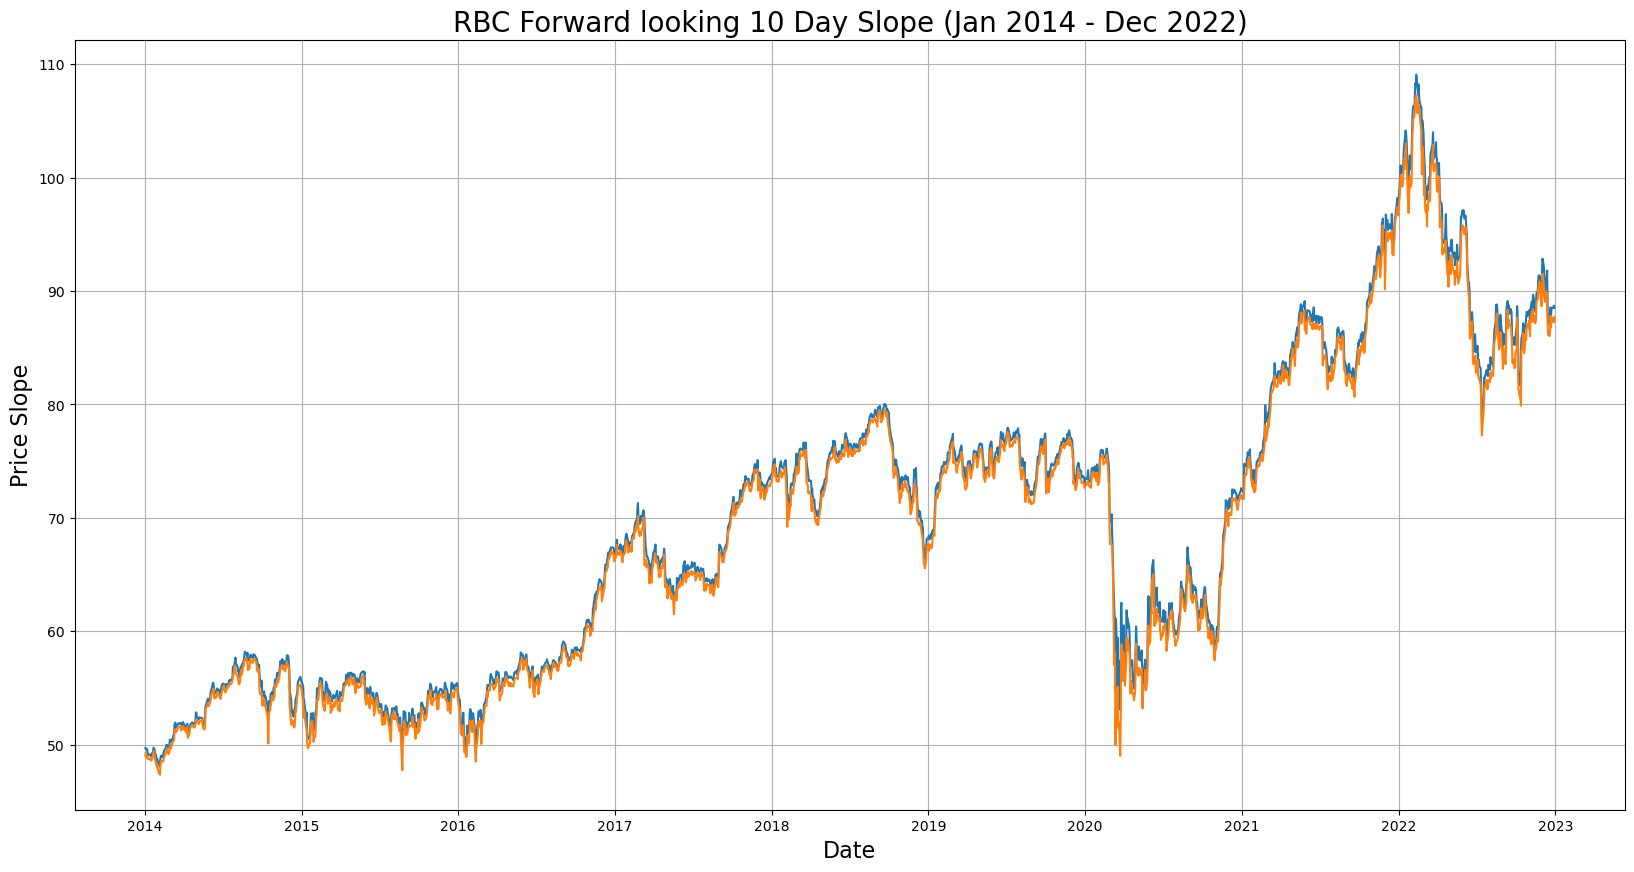

In [4]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['High']], label='High')
plt.plot(df[['Low']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


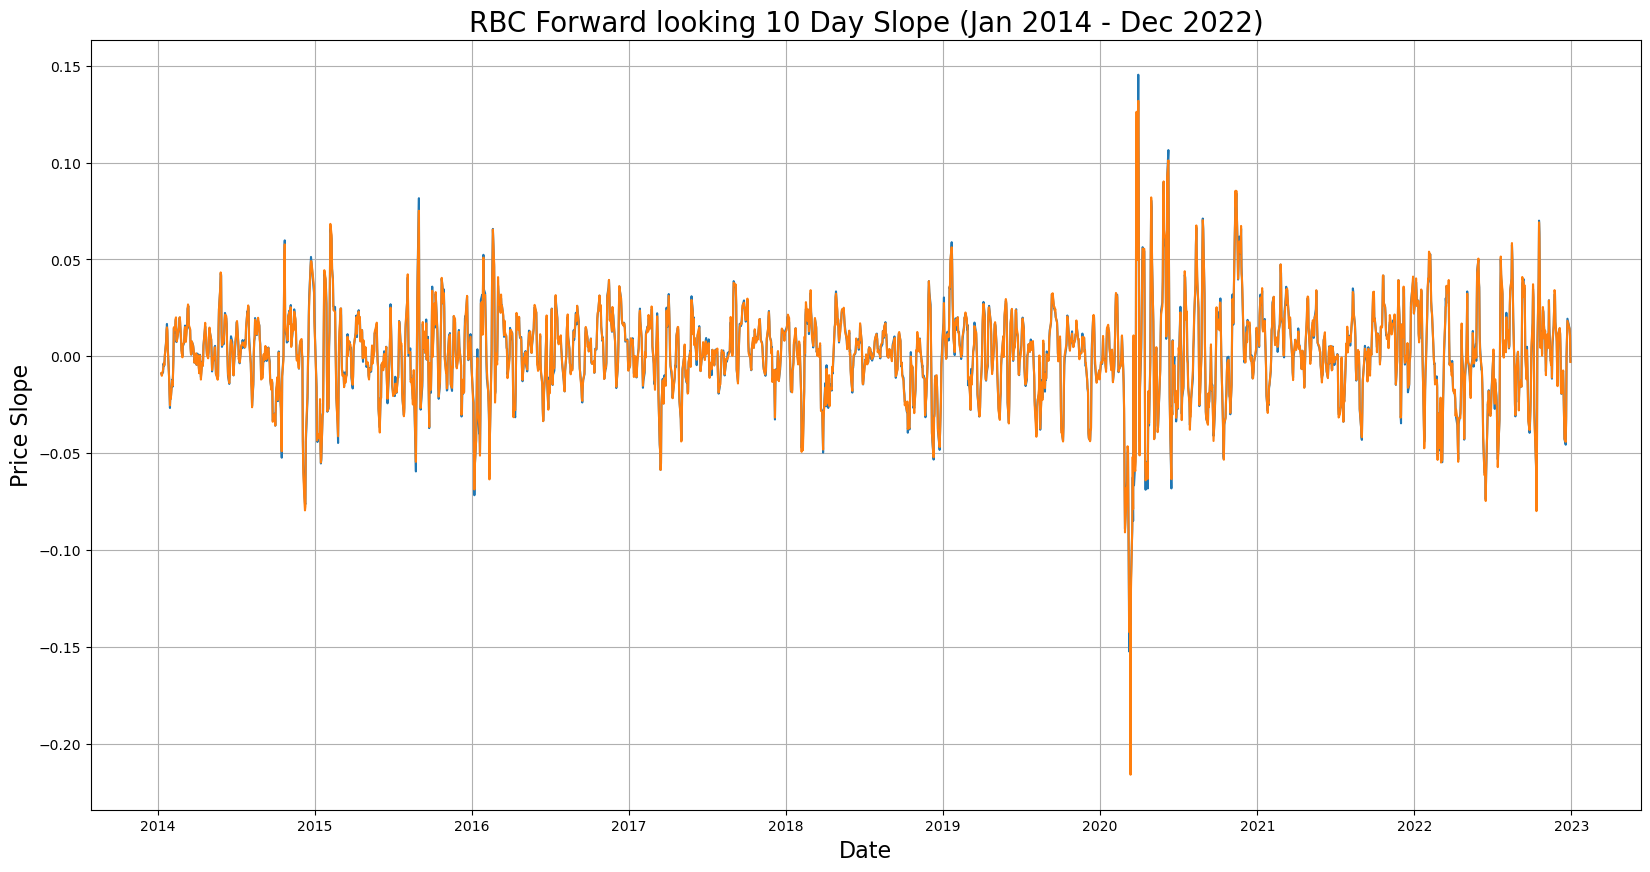

In [5]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Returns_5Day_Moc']], label='Open-Close')
plt.plot(df[['Returns_5Day_Mhloc']], label='High-Low-Open-Close')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


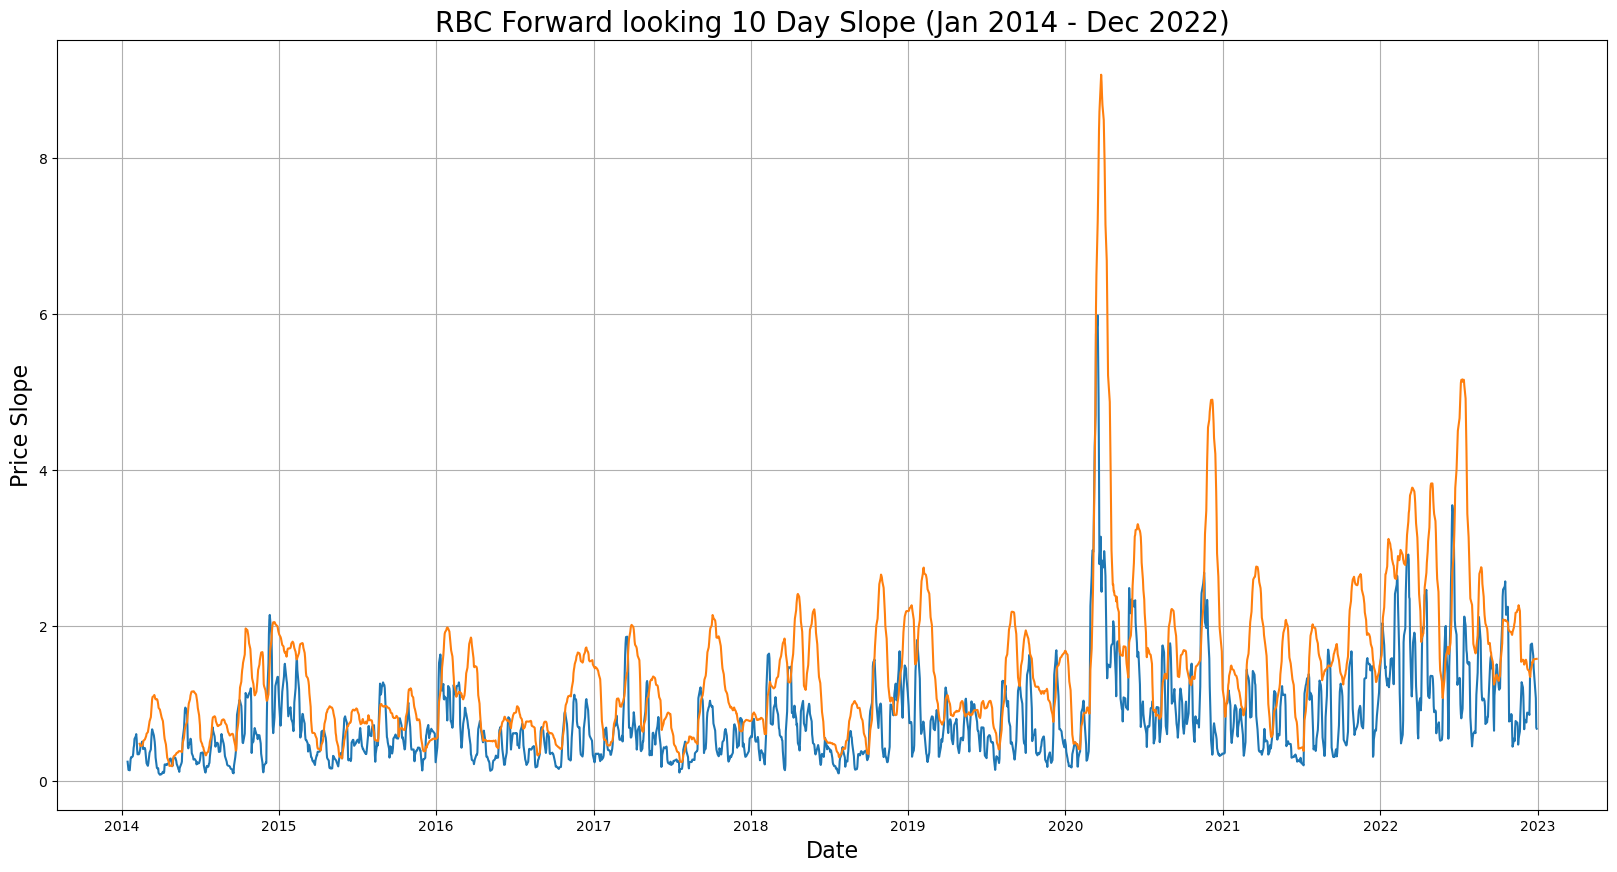

In [6]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['Std_Dev_10Day_Moc']], label='High')
plt.plot(df[['Std_Dev_30Day_Moc']], label='Low')
#plt.title("Royal Bank of Canada (RY) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
#plt.legend('High', 'Low')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [7]:
# Prepare df for trend determination
df = df.sort_index()
df = df.reset_index()
df

Date       Open       High        Low      Close  \
0    2014-01-02 00:00:00-05:00  49.669998  49.700001  49.020000  49.435001   
1    2014-01-03 00:00:00-05:00  49.450001  49.610001  49.325001  49.424999   
2    2014-01-06 00:00:00-05:00  49.610001  49.619999  48.849998  48.994999   
3    2014-01-07 00:00:00-05:00  49.105000  49.389999  48.955002  48.955002   
4    2014-01-08 00:00:00-05:00  49.090000  49.154999  48.735001  49.040001   
...                        ...        ...        ...        ...        ...   
2253 2022-12-22 00:00:00-05:00  87.790001  87.839996  86.820000  87.820000   
2254 2022-12-23 00:00:00-05:00  87.820000  88.440002  87.730003  88.330002   
2255 2022-12-28 00:00:00-05:00  88.290001  88.599998  87.250000  87.559998   
2256 2022-12-29 00:00:00-05:00  87.860001  88.720001  87.720001  88.540001   
2257 2022-12-30 00:00:00-05:00  88.199997  88.510002  87.320000  87.669998   

      Adj Close    Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0     34.867481   3221200  49.360001  49.552500  49.456250  ...   
1     34.860424   2152600  49.467501  49.437500  49.452500  ...   
2     34.557133   3970600  49.234999  49.302500  49.268749  ...   
3     34.528927   2615400  49.172501  49.030001  49.101251  ...   
4     34.588871   3485000  48.945000  49.065001  49.005000  ...   
...         ...       ...        ...        ...        ...  ...   
2253  86.870697   5391900  87.329998  87.805000  87.567499  ...   
2254  87.375191   4177900  88.085003  88.075001  88.080002  ...   
2255  86.613510   5697100  87.924999  87.924999  87.924999  ...   
2256  87.582916   8494300  88.220001  88.200001  88.210001  ...   
2257  86.722321  10549700  87.915001  87.934998  87.924999  ...   

      Returns_5Day_Mhloc  Returns_30Day_Mhloc  Std_Dev_10Day_Moc  \
0                    NaN                  NaN                NaN   
1                    NaN                  NaN                NaN   
2                    NaN                  NaN                NaN   
3                    NaN                  NaN                NaN   
4                    NaN                  NaN                NaN   
...                  ...                  ...                ...   
2253            0.009627            -0.017007           1.611924   
2254            0.018295            -0.008024           1.449571   
2255            0.014129            -0.002977           1.066585   
2256            0.010424             0.001590           0.687970   
2257           -0.002948             0.001167           0.675023   

      Std_Dev_30Day_Moc  Std_Dev_10Day_Mhloc  Std_Dev_30Day_Mhloc  \
0                   NaN                  NaN                  NaN   
1                   NaN                  NaN                  NaN   
2                   NaN                  NaN                  NaN   
3                   NaN                  NaN                  NaN   
4                   NaN                  NaN                  NaN   
...                 ...                  ...                  ...   
2253           1.549596             1.596833             1.554106   
2254           1.565946             1.413794             1.567848   
2255           1.570975             1.048213             1.574973   
2256           1.571219             0.680209             1.571441   
2257           1.571820             0.662327             1.568240   

      SMA_Returns_8Day_Mhloc  SMA_Returns_20Day_Mhloc  \
0                        NaN                      NaN   
1                        NaN                      NaN   
2                        NaN                      NaN   
3                        NaN                      NaN   
4                        NaN                      NaN   
...                      ...                      ...   
2253                0.011003                 0.009619   
2254                0.011181                 0.009665   
2255                0.007797                 0.009577   
2256                0.005401                 0.009561   
2257       

In [8]:
# Calculate the 10-day forward looking slope of daily price benchmarks 
# Slope = coefecient from sklearn regression model
# Price Benchmarks = high, low, open, close

# Initialize X variable 1-10 
X = np.array([[1],[2],[3],[4],[5],[6],[7],[8],[9],[10]])

# Initialize results dataframe
df_target_y = pd.DataFrame(columns = ['index', 'high_slope','high_intercept', 'mid_hl_slope', 'mid_hl_intercept', 'mid_oc_slope', 'mid_oc_intercept', 'low_slope', 'low_intercept', 'trend_10day'])

# Calculate from 1st to last less 10 days
for i in range(len(df) - 10):
    
    # Initialize y variables
    trend = 10
    y_High = np.array([])
    y_Mid_hl = np.array([])
    y_Mid_oc = np.array([])
    y_Low = np.array([])
    count = 0
    
    # Calculate y variables and add them to the array
    for j in range (i , i + 10):
        y_High = np.insert(y_High, len(y_High), df['High'].iloc[[j]])
        y_Mid_hl = np.insert(y_Mid_hl, len(y_Mid_hl), (df['High'].iloc[[j]] + df['Low'].iloc[[j]])/2)
        y_Mid_oc = np.insert(y_Mid_oc, len(y_Mid_oc), (df['Open'].iloc[[j]] + df['Close'].iloc[[j]])/2)
        y_Low = np.insert(y_Low, len(y_Low), df['Low'].iloc[[j]])
        count += 1
    
    # Reshape the y array for the regression model   
    y_High = y_High.reshape(-1,1)
    y_Mid_hl = y_Mid_hl.reshape(-1,1)
    y_Mid_oc = y_Mid_oc.reshape(-1,1)
    y_Low = y_Low.reshape(-1,1)
    
    # Regression models
    reg_High = LinearRegression().fit(X, y_High)
    reg_Mid_hl = LinearRegression().fit(X, y_Mid_hl)
    reg_Mid_oc = LinearRegression().fit(X, y_Mid_oc)
    reg_Low = LinearRegression().fit(X, y_Low)
    
    # Determine trend 
    # 0 - Down = 3 negative coefecients or 2 negative and the sum of all 4 is negative
    # 1 - Up   = 3 positive coefecients or 2 positive and the sum of all 4 is positive
    if (reg_High.coef_ > 0 and reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0): 
        trend = 1
    elif (reg_Mid_hl.coef_ > 0 and reg_Mid_oc.coef_ > 0 and reg_Low.coef_ > 0):
        trend = 1
    elif (reg_High.coef_ < 0 and reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0):
        trend = 0
    elif (reg_High.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0): 
        trend = 0
    elif (reg_Mid_hl.coef_ < 0 and reg_Mid_oc.coef_ < 0 and reg_Low.coef_ < 0):
        trend = 0
    elif (reg_High.coef_  + reg_Mid_hl.coef_ + reg_Mid_oc.coef_ + reg_Low.coef_ > 0):
        trend = 1    
    else: 
        trend =0
    
    # Populate result dataframe
    df_temp = pd.DataFrame({"index":i,  "high_slope": reg_High.coef_[0],     "high_intercept": reg_High.intercept_[0], 
                                        "mid_hl_slope": reg_Mid_hl.coef_[0], "mid_hl_intercept": reg_Mid_hl.intercept_[0],
                                        "mid_oc_slope": reg_Mid_oc.coef_[0], "mid_oc_intercept": reg_Mid_oc.intercept_[0], 
                                        "low_slope": reg_Low.coef_[0],       "low_intercept": reg_Low.intercept_[0],
                                        "trend_10day": trend})
    
    df_target_y = pd.concat([df_target_y,df_temp], axis = "rows")
    
    #print(f" row {i} xxx High: {reg_High.coef_} xxx Mid HiLo: {reg_Mid_hl.coef_} xxx Mid OpCl: {reg_Mid_oc.coef_} xxx Low: {reg_Low.coef_} xxx {trend}")
    #print('========================')

# Display result Dataframe
df_target_y = df_target_y.set_index(['index'])
display(df_target_y)

C:\Users\jersk\anaconda3\lib\site-packages\pandas\core\indexes\base.py:6999: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  return Index(sequences[0], name=names)


high_slope  high_intercept  mid_hl_slope  mid_hl_intercept  \
index                                                               
0       -0.080909       49.741000     -0.065485         49.435667   
1       -0.073939       49.625666     -0.063864         49.366500   
2       -0.047818       49.442998     -0.034409         49.157999   
3       -0.007576       49.197665     -0.002545         48.981999   
4        0.039334       48.973665      0.044061         48.765666   
...           ...             ...           ...               ...   
2243    -0.408970       91.355335     -0.390515         90.569334   
2244    -0.421091       91.210003     -0.377485         90.279669   
2245    -0.311455       90.360001     -0.235849         89.266668   
2246    -0.138485       89.140669     -0.063909         88.055002   
2247     0.108182       87.476000      0.119364         86.866001   

       mid_oc_slope  mid_oc_intercept  low_slope  low_intercept trend_10day  
index                                                                        
0         -0.078106         49.532333  -0.050061      49.130333           0  
1         -0.060955         49.369500  -0.053788      49.107334           0  
2         -0.037712         49.194667  -0.021000      48.873000           0  
3         -0.000864         48.989500   0.002485      48.766334           0  
4          0.029030         48.869833   0.048788      48.557667           1  
...             ...               ...        ...            ...         ...  
2243      -0.412061         90.702335  -0.372060      89.783333           0  
2244      -0.363212         90.245668  -0.333879      89.349335           0  
2245      -0.238849         89.343668  -0.160242      88.173334           0  
2246      -0.057909         88.058000   0.010667      86.969335           0  
2247       0.127909         86.841000   0.130545      86.256002           1  

[2248 rows x 9 columns]

In [9]:
df = pd.concat([df, df_target_y], axis= 1)
display(df.head(11))
display(df.tail(11))

Date       Open       High        Low      Close  \
0  2014-01-02 00:00:00-05:00  49.669998  49.700001  49.020000  49.435001   
1  2014-01-03 00:00:00-05:00  49.450001  49.610001  49.325001  49.424999   
2  2014-01-06 00:00:00-05:00  49.610001  49.619999  48.849998  48.994999   
3  2014-01-07 00:00:00-05:00  49.105000  49.389999  48.955002  48.955002   
4  2014-01-08 00:00:00-05:00  49.090000  49.154999  48.735001  49.040001   
5  2014-01-09 00:00:00-05:00  49.174999  49.189999  48.724998  49.029999   
6  2014-01-10 00:00:00-05:00  49.099998  49.099998  48.770000  48.845001   
7  2014-01-13 00:00:00-05:00  48.900002  49.099998  48.810001  48.900002   
8  2014-01-14 00:00:00-05:00  49.049999  49.099998  48.639999  48.639999   
9  2014-01-15 00:00:00-05:00  48.840000  48.994999  48.720001  48.799999   
10 2014-01-16 00:00:00-05:00  48.830002  48.930000  48.584999  48.904999   

    Adj Close   Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
0   34.867481  3221200  49.360001  49.552500  49.456250  ...   
1   34.860424  2152600  49.467501  49.437500  49.452500  ...   
2   34.557133  3970600  49.234999  49.302500  49.268749  ...   
3   34.528927  2615400  49.172501  49.030001  49.101251  ...   
4   34.588871  3485000  48.945000  49.065001  49.005000  ...   
5   34.581814  2502400  48.957499  49.102499  49.029999  ...   
6   34.451340  2720800  48.934999  48.972500  48.953750  ...   
7   34.490131  2576000  48.955000  48.900002  48.927501  ...   
8   34.306744  3289800  48.869999  48.844999  48.857499  ...   
9   34.419598  2739600  48.857500  48.820000  48.838750  ...   
10  34.493660  3258800  48.757500  48.867500  48.812500  ...   

    SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
0                          1   -0.080909       49.741000     -0.065485   
1                          1   -0.073939       49.625666     -0.063864   
2                          1   -0.047818       49.442998     -0.034409   
3                          1   -0.007576       49.197665     -0.002545   
4                          1    0.039334       48.973665      0.044061   
5                          1    0.063728       48.891998      0.066697   
6                          1    0.081637       48.837999      0.082076   
7                          1    0.073970       48.907666      0.069364   
8                          0    0.044151       49.064666      0.031273   
9                          0   -0.000909       49.276000     -0.014652   
10                         0   -0.054000       49.532001     -0.069985   

    mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
0          49.435667     -0.078106         49.532333  -0.050061   
1          49.366500     -0.060955         49.369500  -0.053788   
2          49.157999     -0.037712         49.194667  -0.021000   
3          48.981999     -0.000864         48.989500   0.002485   
4          48.765666      0.029030         48.869833   0.048788   
5          48.696666      0.064424         48.732166   0.069667   
6          48.663833      0.085591         48.651000   0.082515   
7          48.750500      0.078818         48.709000   0.064758   
8          48.929500      0.041242         48.900667   0.018394   
9          49.149334     -0.007727         49.143000  -0.028394   
10         49.399167     -0.069545         49.432000  -0.085970   

    low_intercept  trend_10day  
0       49.130333            0  
1       49.107334            0  
2       48.873000            0  
3       48.766334            0  
4       48.557667            1  
5       48.501333            1  
6       48.489668            1  
7       48.593334            1  
8       48.794333            1  
9       49.022667            0  
10      49.266333            0  

[11 rows x 34 columns]

Date       Open       High        Low      Close  \
2247 2022-12-14 00:00:00-05:00  88.699997  88.870003  87.480003  87.500000   
2248 2022-12-15 00:00:00-05:00  86.800003  87.070000  86.160004  86.900002   
2249 2022-12-16 00:00:00-05:00  86.169998  87.099998  86.089996  86.629997   
2250 2022-12-19 00:00:00-05:00  86.760002  87.389999  86.040001  86.610001   
2251 2022-12-20 00:00:00-05:00  86.900002  88.120003  86.620003  87.559998   
2252 2022-12-21 00:00:00-05:00  88.250000  88.559998  87.830002  88.099998   
2253 2022-12-22 00:00:00-05:00  87.790001  87.839996  86.820000  87.820000   
2254 2022-12-23 00:00:00-05:00  87.820000  88.440002  87.730003  88.330002   
2255 2022-12-28 00:00:00-05:00  88.290001  88.599998  87.250000  87.559998   
2256 2022-12-29 00:00:00-05:00  87.860001  88.720001  87.720001  88.540001   
2257 2022-12-30 00:00:00-05:00  88.199997  88.510002  87.320000  87.669998   

      Adj Close    Volume     Mid_hl     Mid_oc   Mid_hloc  ...  \
2247  86.554161   2953600  88.175003  88.099998  88.137501  ...   
2248  85.960648   5176100  86.615002  86.850002  86.732502  ...   
2249  85.693565  12453200  86.594997  86.399998  86.497498  ...   
2250  85.673782   6218400  86.715000  86.685001  86.700001  ...   
2251  86.613510   6312400  87.370003  87.230000  87.300001  ...   
2252  87.147675   3299100  88.195000  88.174999  88.184999  ...   
2253  86.870697   5391900  87.329998  87.805000  87.567499  ...   
2254  87.375191   4177900  88.085003  88.075001  88.080002  ...   
2255  86.613510   5697100  87.924999  87.924999  87.924999  ...   
2256  87.582916   8494300  88.220001  88.200001  88.210001  ...   
2257  86.722321  10549700  87.915001  87.934998  87.924999  ...   

      SMA_Signal_8_20Day_Mhloc  high_slope  high_intercept  mid_hl_slope  \
2247                         0    0.108182          87.476      0.119364   
2248                         0         NaN             NaN           NaN   
2249                         0         NaN             NaN           NaN   
2250                         0         NaN             NaN           NaN   
2251                         0         NaN             NaN           NaN   
2252                         0         NaN             NaN           NaN   
2253                         0         NaN             NaN           NaN   
2254                         0         NaN             NaN           NaN   
2255                         0         NaN             NaN           NaN   
2256                         0         NaN             NaN           NaN   
2257                         0         NaN             NaN           NaN   

      mid_hl_intercept  mid_oc_slope  mid_oc_intercept  low_slope  \
2247         86.866001      0.127909            86.841   0.130545   
2248               NaN           NaN               NaN        NaN   
2249               NaN           NaN               NaN        NaN   
2250               NaN           NaN               NaN        NaN   
2251               NaN           NaN               NaN        NaN   
2252               NaN           NaN               NaN        NaN   
2253               NaN           NaN               NaN        NaN   
2254               NaN           NaN               NaN        NaN   
2255               NaN           NaN               NaN        NaN   
2256               NaN           NaN               NaN        NaN   
2257               NaN           NaN               NaN        NaN   

      low_intercept  trend_10day  
2247      86.256002            1  
2248            NaN          NaN  
2249            NaN          NaN  
2250            NaN          NaN  
2251            NaN          NaN  
2252            NaN          NaN  
2253            NaN          NaN  
2254            NaN          NaN  
2255            NaN          NaN  
2256            NaN          NaN  
2257            NaN          NaN  

[11 rows x 34 columns]

In [10]:
df = df.set_index(['Date'])
display(df.head(11))
display(df.tail(11))


Open       High        Low      Close  \
Date                                                                    
2014-01-02 00:00:00-05:00  49.669998  49.700001  49.020000  49.435001   
2014-01-03 00:00:00-05:00  49.450001  49.610001  49.325001  49.424999   
2014-01-06 00:00:00-05:00  49.610001  49.619999  48.849998  48.994999   
2014-01-07 00:00:00-05:00  49.105000  49.389999  48.955002  48.955002   
2014-01-08 00:00:00-05:00  49.090000  49.154999  48.735001  49.040001   
2014-01-09 00:00:00-05:00  49.174999  49.189999  48.724998  49.029999   
2014-01-10 00:00:00-05:00  49.099998  49.099998  48.770000  48.845001   
2014-01-13 00:00:00-05:00  48.900002  49.099998  48.810001  48.900002   
2014-01-14 00:00:00-05:00  49.049999  49.099998  48.639999  48.639999   
2014-01-15 00:00:00-05:00  48.840000  48.994999  48.720001  48.799999   
2014-01-16 00:00:00-05:00  48.830002  48.930000  48.584999  48.904999   

                           Adj Close   Volume     Mid_hl     Mid_oc  \
Date                                                                  
2014-01-02 00:00:00-05:00  34.867481  3221200  49.360001  49.552500   
2014-01-03 00:00:00-05:00  34.860424  2152600  49.467501  49.437500   
2014-01-06 00:00:00-05:00  34.557133  3970600  49.234999  49.302500   
2014-01-07 00:00:00-05:00  34.528927  2615400  49.172501  49.030001   
2014-01-08 00:00:00-05:00  34.588871  3485000  48.945000  49.065001   
2014-01-09 00:00:00-05:00  34.581814  2502400  48.957499  49.102499   
2014-01-10 00:00:00-05:00  34.451340  2720800  48.934999  48.972500   
2014-01-13 00:00:00-05:00  34.490131  2576000  48.955000  48.900002   
2014-01-14 00:00:00-05:00  34.306744  3289800  48.869999  48.844999   
2014-01-15 00:00:00-05:00  34.419598  2739600  48.857500  48.820000   
2014-01-16 00:00:00-05:00  34.493660  3258800  48.757500  48.867500   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2014-01-02 00:00:00-05:00  49.456250        0.610295  ...   
2014-01-03 00:00:00-05:00  49.452500        0.350872  ...   
2014-01-06 00:00:00-05:00  49.268749        0.188312  ...   
2014-01-07 00:00:00-05:00  49.101251        0.000000  ...   
2014-01-08 00:00:00-05:00  49.005000        0.726194  ...   
2014-01-09 00:00:00-05:00  49.029999        0.655914  ...   
2014-01-10 00:00:00-05:00  48.953750        0.227276  ...   
2014-01-13 00:00:00-05:00  48.927501        0.310348  ...   
2014-01-14 00:00:00-05:00  48.857499        0.000000  ...   
2014-01-15 00:00:00-05:00  48.838750        0.290904  ...   
2014-01-16 00:00:00-05:00  48.812500        0.927532  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2014-01-02 00:00:00-05:00                         1   -0.080909   
2014-01-03 00:00:00-05:00                         1   -0.073939   
2014-01-06 00:00:00-05:00                         1   -0.047818   
2014-01-07 00:00:00-05:00                         1   -0.007576   
2014-01-08 00:00:00-05:00                         1    0.039334   
2014-01-09 00:00:00-05:00                         1    0.063728   
2014-01-10 00:00:00-05:00                         1    0.081637   
2014-01-13 00:00:00-05:00                         1    0.073970   
2014-01-14 00:00:00-05:00                         0    0.044151   
2014-01-15 00:00:00-05:00                         0   -0.000909   
2014-01-16 00:00:00-05:00                         0   -0.054000   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2014-01-02 00:00:00-05:00       49.741000     -0.065485         49.435667   
2014-01-03 00:00:00-05:00       49.625666     -0.063864         49.366500   
2014-01-06 00:00:00-05:00       49.442998     -0.034409         49.157999   
2014-01-07 00:00:00-05:00       49.197665     -0.002545         48.981999   
2014-01-08 00:00:00-05:00     

Open       High        Low      Close  \
Date                                                                    
2022-12-14 00:00:00-05:00  88.699997  88.870003  87.480003  87.500000   
2022-12-15 00:00:00-05:00  86.800003  87.070000  86.160004  86.900002   
2022-12-16 00:00:00-05:00  86.169998  87.099998  86.089996  86.629997   
2022-12-19 00:00:00-05:00  86.760002  87.389999  86.040001  86.610001   
2022-12-20 00:00:00-05:00  86.900002  88.120003  86.620003  87.559998   
2022-12-21 00:00:00-05:00  88.250000  88.559998  87.830002  88.099998   
2022-12-22 00:00:00-05:00  87.790001  87.839996  86.820000  87.820000   
2022-12-23 00:00:00-05:00  87.820000  88.440002  87.730003  88.330002   
2022-12-28 00:00:00-05:00  88.290001  88.599998  87.250000  87.559998   
2022-12-29 00:00:00-05:00  87.860001  88.720001  87.720001  88.540001   
2022-12-30 00:00:00-05:00  88.199997  88.510002  87.320000  87.669998   

                           Adj Close    Volume     Mid_hl     Mid_oc  \
Date                                                                   
2022-12-14 00:00:00-05:00  86.554161   2953600  88.175003  88.099998   
2022-12-15 00:00:00-05:00  85.960648   5176100  86.615002  86.850002   
2022-12-16 00:00:00-05:00  85.693565  12453200  86.594997  86.399998   
2022-12-19 00:00:00-05:00  85.673782   6218400  86.715000  86.685001   
2022-12-20 00:00:00-05:00  86.613510   6312400  87.370003  87.230000   
2022-12-21 00:00:00-05:00  87.147675   3299100  88.195000  88.174999   
2022-12-22 00:00:00-05:00  86.870697   5391900  87.329998  87.805000   
2022-12-23 00:00:00-05:00  87.375191   4177900  88.085003  88.075001   
2022-12-28 00:00:00-05:00  86.613510   5697100  87.924999  87.924999   
2022-12-29 00:00:00-05:00  87.582916   8494300  88.220001  88.200001   
2022-12-30 00:00:00-05:00  86.722321  10549700  87.915001  87.934998   

                            Mid_hloc  Close_in_range  ...  \
Date                                                  ...   
2022-12-14 00:00:00-05:00  88.137501        0.014386  ...   
2022-12-15 00:00:00-05:00  86.732502        0.813188  ...   
2022-12-16 00:00:00-05:00  86.497498        0.534653  ...   
2022-12-19 00:00:00-05:00  86.700001        0.422222  ...   
2022-12-20 00:00:00-05:00  87.300001        0.626663  ...   
2022-12-21 00:00:00-05:00  88.184999        0.369861  ...   
2022-12-22 00:00:00-05:00  87.567499        0.980395  ...   
2022-12-23 00:00:00-05:00  88.080002        0.845069  ...   
2022-12-28 00:00:00-05:00  87.924999        0.229628  ...   
2022-12-29 00:00:00-05:00  88.210001        0.820000  ...   
2022-12-30 00:00:00-05:00  87.924999        0.294116  ...   

                           SMA_Signal_8_20Day_Mhloc  high_slope  \
Date                                                              
2022-12-14 00:00:00-05:00                         0    0.108182   
2022-12-15 00:00:00-05:00                         0         NaN   
2022-12-16 00:00:00-05:00                         0         NaN   
2022-12-19 00:00:00-05:00                         0         NaN   
2022-12-20 00:00:00-05:00                         0         NaN   
2022-12-21 00:00:00-05:00                         0         NaN   
2022-12-22 00:00:00-05:00                         0         NaN   
2022-12-23 00:00:00-05:00                         0         NaN   
2022-12-28 00:00:00-05:00                         0         NaN   
2022-12-29 00:00:00-05:00                         0         NaN   
2022-12-30 00:00:00-05:00                         0         NaN   

                           high_intercept  mid_hl_slope  mid_hl_intercept  \
Date                                                                        
2022-12-14 00:00:00-05:00          87.476      0.119364         86.866001   
2022-12-15 00:00:00-05:00             NaN           NaN               NaN   
2022-12-16 00:00:00-05:00             NaN           NaN               NaN   
2022-12-19 00:00:00-05:00             NaN           NaN               NaN   
2022-12-20 00:00:

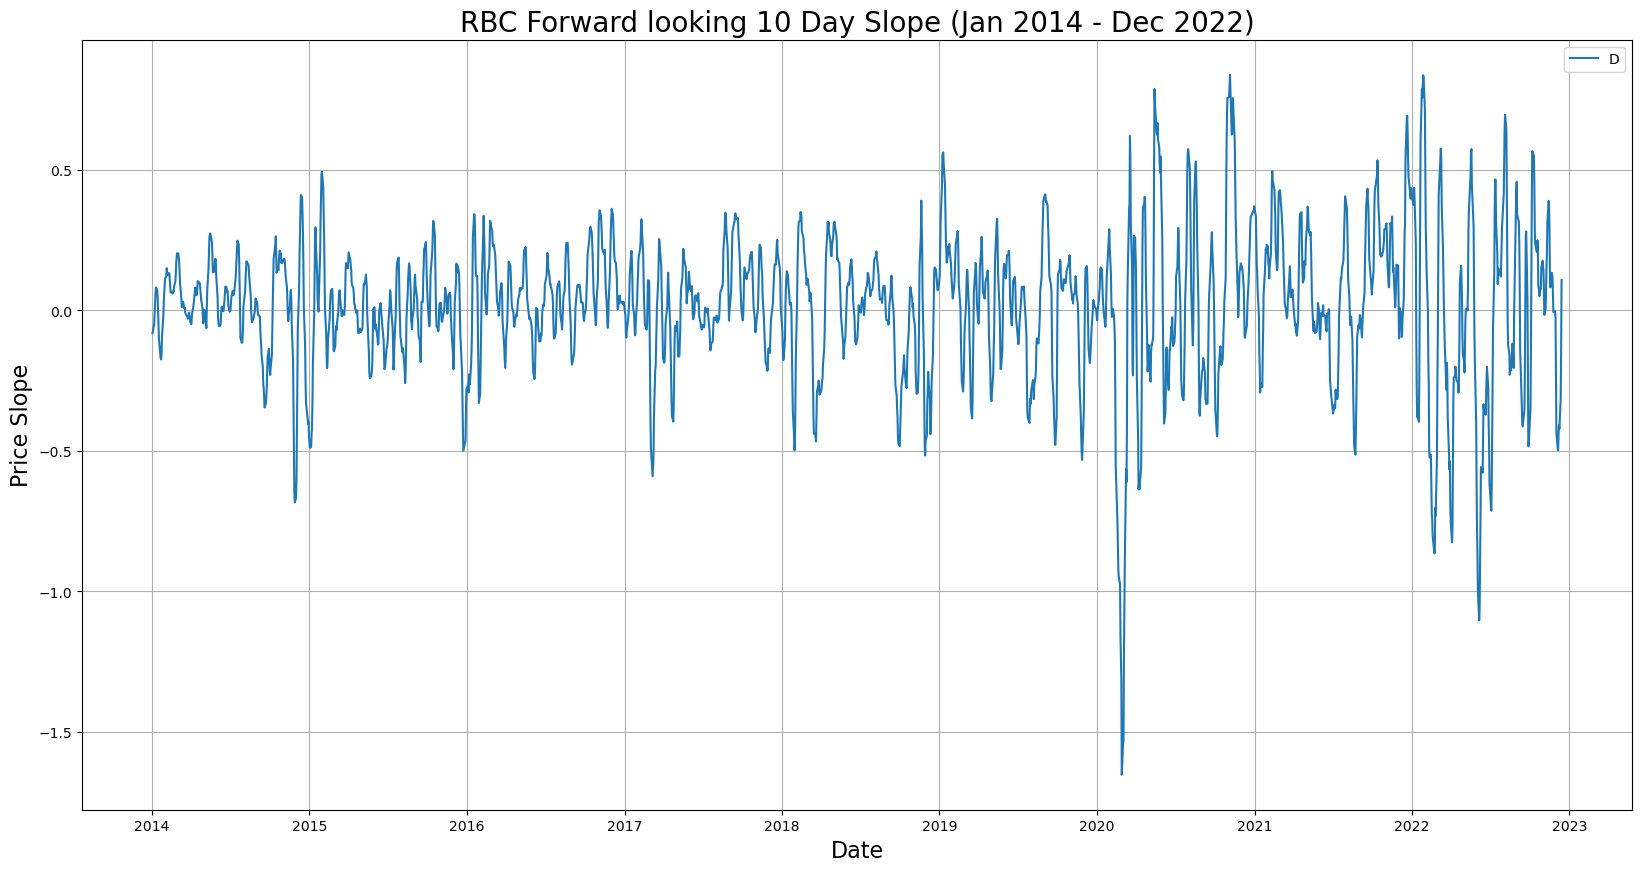

In [11]:
# Plot daily returns of all portfolios
fig = plt.figure(figsize=(20,10))

#plt.plot(df_all_stocks_model[['RY.TO']])
plt.plot(df[['high_slope']])
#plt.title("Bank of Montreal (BMO) Daily Close (Jan 2014 - Sep 2022)", fontsize = 20)
plt.title("RBC Forward looking 10 Day Slope (Jan 2014 - Dec 2022)", fontsize = 20)
plt.ylabel("Price Slope", fontsize = 16)
plt.xlabel("Date", fontsize = 16)
plt.legend('Daily High')
#plt.legend(df_RYx.columns)
plt.grid()

plt.show()


In [12]:
df.to_csv('../Data/Feature_Engineering_TD.csv', encoding='utf-8')